## Project Description

- Briefly Explain Your Project
- Describe your dataset and classes

### Hyperparameter Optimization with Optuna

- [Optuna](https://optuna.org/) is one of the most famous Hyperparameter optimization libraries in practice. It allows us to quickly identify the optimal hyperparamters resulting the best model. 
- Besides from searching the optimal parameters in hyperparamater space, Optuna also provides several early stopping strategies to prune unpromising trials earlier to save the training time.

### Visualization of Feature Maps with Pytorch Hooks

- Recall that in neural networks, we apply a group of filters to the previous layer and obtain what we call feature maps. We then send these feature maps to the next layer. Each layer applies some filters(kernels) whichare able to extract information like edges, round-shapes etc.
- We can visualize these feature maps by catching them via Pytorch's built-in hooking method. Note that such an analysis is not part of a typical deep learning task. However, we can inspect literally what the model is learning with this.

### Transfer Learning with EfficientNet


- Instead of trying to build a model from scratch, we will employ one of the pre-trained state-of-the-art image recognition architecture "EfficientNet". Orginal paper published by Google researchers is [here](https://arxiv.org/abs/1905.11946). You can also have a look at the video [here](https://www.youtube.com/watch?v=3svIm5UC94I) for the brief summary of this paper.


<img src="results/efficient.png" alt="Drawing" style="width: 400px;"/>

- The idea is to download and modify the model based on our problem. This process is called **transfer learning**. Unless the problem in consideration requires completely new architecture(which is super super rare), this is how we should handle image recognition problems. There tons of videos online, please search and watch some.
- To be more precise, almost all of computer vision models consist of a layer called "classification(segmentation etc) head" at the end of the architecture. We first modify this head based on our model. In a classification task, we have to change the number outputs(i.e. number of classes) in bare minimum. We can add new layers as well.
- For example, EfficientNet has 1000 output features since it was trained on ImageNet dataset. We will change to it to 5, which is our number of classes.

After that we two options:
- (1) We can **freeze** all the layers of the model and train only the sections we added. This means gradients will be propagated through the early layer. In other words, we do not change the parameters in the early layers. This road is very fast since we train only a fraction (say few thousands out of ~15M) of the parameters in the system.
- (2) After modifying the last layers, we can actually train the entire model. Although this process requires significantly more resources, it usually results in better results.
-  We will create a simple function to get "efficient-net" and try both types of training to see which one gives better result.

### Auto Augmentation Policy


- Wikipedia is a great intro sentence for this task "*Data augmentation in data analysis are techniques used to increase the amount of data by adding **slightly modified** copies of already existing data or newly created **synthetic** data from existing data. It acts as a **regularizer** and helps reduce **overfitting** when training a machine learning model*"
- First contemplate on the bold words above... Idea is to slightly alter the data in each training cycle so as to train the model on different versions of the data. For example, rotate, blur, add noise to images (with some probability in general).
- We actually introduced shuffling as part of this scheme and also resized the 224x224 images to 60x60.  
- We will add more data augmentation using Pytorch's built-in transformers class. We will also start using the original 224x224 images.
- In the previous notebook, we used some random augmentations. Now, we will rely on [ImageNet policies](https://ai.googleblog.com/2018/06/improving-deep-learning-performance.html). The orginal paper is [here](https://arxiv.org/abs/1805.09501). This is one of most common automated approaches to find data augmentation policies from the data itself. Recall that the EfficientNet was trained on ImageNet. Thus, this approach conceptually should improve our results.

### Handling Imbalanced Data

- As we observed before, bathroom class is underrepresented in the training data comparing to others. There are two mainstream methods to deal with this problem. First one is to oversample the minority class. The idea is to provide almost equal representation to all classses during the training proces. There are several methods in Pytorch to achive this, for example one can use WeightedRandomSampler method. 
- Second method is to provide class weights to the cost function to amplify the error made in minority classes so that the gradient agressively learns the minority class. 
- We will use the second method in this notebook. GetSampleWeights function returns both class weights for the second method as well sample weights for the first method. For oversampling, simply uncomment two lines in GetLoaders function and provide the sampler to train_loader accordingly. 

### Regularization

- The basic idea of regularization is to add a penalty term to the cost function. What this does is to reduce the effect of the activation function,i.e, we don’t allow the model to fully utilize its free variables. So we interpolate the data with less complex function. This, in turn, effectively reduces overfitting.
- In Pytorch, introduce weight_decay in optimizer scheme. Check this [video](https://www.youtube.com/watch?v=wSb3PXS8g8w) to learn more.

## Preprocessing and Data Loading

### Import necessary modules

In [1]:
colab = False
if colab:
    from google.colab import drive
    from google.colab import files

    drive.mount('/content/drive')

    #import modules here if necessary
    !pip install torchinfo
    !pip install timm
    !pip install captum
    !pip install optuna
    !pip install -U kaleido

    #make-dirs
    !mkdir -p '/content/hair_data/train'
    !mkdir -p '/content/hair_data/test'
    !mkdir -p '/content/results/'
    
    #define test-train-ext dirs
    train_dir = '/content/hair_data/train'
    test_dir = '/content/hair_data/test'
    ext_dir = '/content/results/'
    

    #modify here
    !unzip -u '/content/drive/MyDrive/ColabNotebooks/SpelmanResearch/princess_last/hair_data/train.zip' -d '/content/hair_data'
    !unzip -u '/content/drive/MyDrive/ColabNotebooks/SpelmanResearch/princess_last/hair_data/test.zip' -d '/content/hair_data'
else:
    #change this to your own local directories if you dont work on Colab
    !mkdir -p 'hair_data/train'
    !mkdir -p 'hair_data/test'
    !mkdir -p 'results/'
    
    train_dir = 'hair_data/train/'
    test_dir = 'hair_data/test'
    ext_dir =  'results/'
   

In [2]:
#==============================#
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
#===========================#
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms,models
import torch.nn.functional as F
from torchvision import datasets
#pretrained-model library
import timm

#model interpretibility
#from captum.attr import Occlusion
#from captum.attr import visualization as viz

#hyperparameter optimization
import optuna
from optuna.trial import FrozenTrial
from optuna import study
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler
#============================#
from collections import Counter
import copy
import os
import random
import joblib
from torchinfo import summary
from sklearn.metrics import confusion_matrix
#progress bar(:
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore') 
#==============================#
%matplotlib inline
#check the computing enviorenment cpu/gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name(0))

NVIDIA GeForce RTX 2070 Super


In [3]:
#set some global variables
study_name = 'HairStudy' 
model_name = 'HairStudyTransferLearning'

In [4]:
#this will make your code repetable to a great extend
def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

### Loading the Data via Pytorch DataLoader

In [5]:
def GetLoaders(train_dir, test_dir, batch_size=8):
    #reading and loading the data
    mean = [0.485, 0.456, 0.406]
    std =  [0.229, 0.224, 0.225]
    training_transforms = transforms.Compose([transforms.Resize((224,224)), 
                                              transforms.AutoAugment(transforms.AutoAugmentPolicy.IMAGENET),
                                            transforms.ToTensor(),
                                            transforms.Normalize(mean,std)
                                             ])
    test_transforms = transforms.Compose([ transforms.Resize((224,224)),
                                          transforms.ToTensor(),
                                         transforms.Normalize(mean,std)
                                         ])

    #uncomment this to use WeightedRandomSampler method described above and add sampler below
    #sample_weights,_ = GetSampleWeights(train_image_paths)
    #sampler = WeightedRandomSampler(sample_weights, num_samples = len(sample_weights),replacement=True)

    train_set = datasets.ImageFolder(train_dir, transform = training_transforms)
    test_set  = datasets.ImageFolder(test_dir, transform = test_transforms)

    train_loader = DataLoader(train_set,batch_size = batch_size,sampler = None, shuffle=True)
    test_loader = DataLoader(test_set,batch_size = batch_size)
    
    return train_loader, test_loader,training_transforms, test_transforms

train_loader, test_loader,training_transforms,test_transforms = GetLoaders(train_dir,test_dir)

In [6]:
class_list = train_loader.dataset.classes
class_to_idx = train_loader.dataset.class_to_idx
print(class_to_idx)
idx_to_class = {i:j for i, j in enumerate(class_list)}
num_classes = len(class_list)
dis_dict = dict(Counter(train_loader.dataset.targets))
class_counts = list(dis_dict.values())
print(class_counts)

{'braid_twist': 0, 'curls': 1, 'cut': 2, 'extended_style': 3, 'locs': 4}
[169, 230, 240, 254, 305]


In [7]:
def GetDataPaths(train_dir,test_dir):
    class_list = []
    train_image_paths = []
    test_image_paths = []
    for (dirpath, dirnames, filenames) in os.walk(train_dir):
        for names in filenames:
            train_image_paths.append(os.path.join(dirpath,names))
    for (dirpath, dirnames, filenames) in os.walk(test_dir):
        for names in filenames:
            test_image_paths.append(os.path.join(dirpath,names))

    random.shuffle(train_image_paths)
    random.shuffle(test_image_paths)
    
    return train_image_paths,test_image_paths

train_image_paths,test_image_paths = GetDataPaths(train_dir, test_dir)

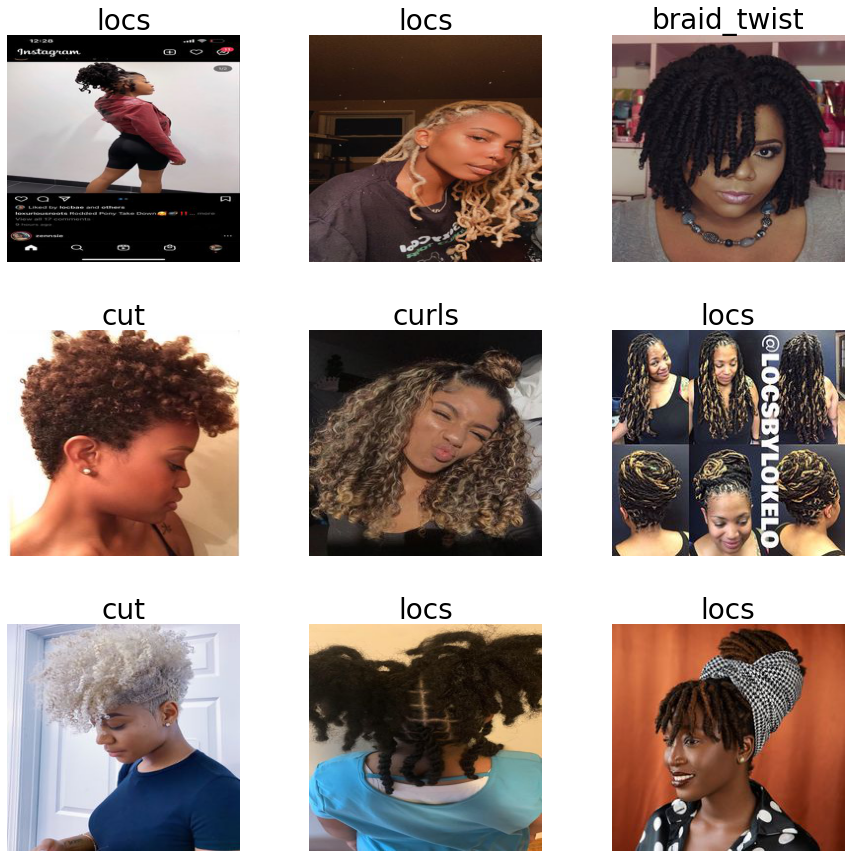

In [8]:
#let's look at some images on nxn grid
def ViewSamples(n,img_paths,name='samples'):
    plt.figure(figsize=(15, 15))
    img_lst = random.sample(img_paths,n*n)
    for i,img_path in enumerate(img_lst):
        img = Image.open(img_path).convert('RGB')
        label  = img_path.split('/')[-2]
        plt.subplot(n, n, i+1) 
        plt.subplots_adjust(hspace=0.3,wspace=0.3)
        plt.imshow(img,aspect='auto')
        plt.title(label,color="black",fontsize=28)
        plt.axis('off')
        plt.savefig(f'{ext_dir}/{name}.jpeg')
    
ViewSamples(3,train_image_paths)

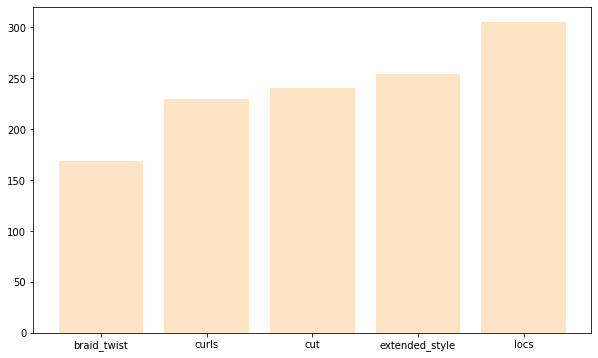

In [9]:
def ShowClassDist(name='classDist'):
    fig, ax = plt.subplots(figsize=(10,6))
    ax.bar(class_list, class_counts, color='bisque')
    plt.xticks(fontsize=10, rotation=0)
    fig.savefig(f'{ext_dir}/{name}.jpeg')
    plt.show()
ShowClassDist()

Notice how the relationship. The lower the representation, higher the class weight.

In [10]:
def GetSampleWeights(train_image_paths):
    class_weights = [1000./count for count in class_counts]

    sample_weights = [0]*len(train_image_paths)
    for i in range(len(train_image_paths)):
        label = train_image_paths[i].split('/')[-2]
        class_weight = class_weights[class_to_idx[label]]
        sample_weights[i] = class_weight
        
    return sample_weights,torch.tensor(class_weights).to(device)

sample_weights,class_weights = GetSampleWeights(train_image_paths)
print(class_weights)

tensor([5.9172, 4.3478, 4.1667, 3.9370, 3.2787], device='cuda:0')


## EfficientNet for Transfer Learning

We will get EfficientNet B0 in this section from timm library. Before creating a function, let's see what we have in this model.   

In [11]:
# model = timm.create_model(model_name = 'efficientnet_b0',pretrained=True)

In [12]:
# summary(model,input_size=(8,3,224,224))

Let's understand the outcome little bit more;
- Look at the classifier head, we have 1000 output neurons. It is because EfficientNet was trained on ImageNet with 1000 classes. We have to change modify this portion and change the output number of classes we have.
- Torchinfo output tells us we have 5,288,548 trainable parameters. It is because we have not "frozen" any layer yet.
- B0 is the base EfficientNet model For the full-model list(b0,b1,b2 etc), check [timm repo](https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/efficientnet.py).
- We can now define the following function. Notice that if freeze=true then requires_grad attribute of model paramaters is set to False. So they will not be trained.
- We add replace classifier head with one connected layer with 100 neurons and also output layer with num_classes neurons. Inspect the torchinfo output again... Out of 4,136,153 parameters only 128,605 is trainable...

In [13]:
def GetModel(version = 'efficientnet_b0',freeze = True):
    model = timm.create_model(model_name = version,pretrained=True)
    if freeze:
        for parameter in model.parameters():
            parameter.requires_grad = False
    
    in_features = model.classifier.in_features # 1792
    
    model.classifier = nn.Sequential(
                          nn.Linear(in_features, 100), 
                          nn.ReLU(), 
                          nn.Linear(100, num_classes),
                                    )
    
    return model

In [14]:
# model = GetModel(version = 'efficientnet_b0',freeze = False)
# summary(model,input_size=(8,3,224,224))

## Hyperparameter Optimization with Optuna


- In a typical supervised learning task, we have training and testing functions. We then call this functions in order to monitor the progress of our model. More precisely, train and test the model in each epoch.
- It is always a good practice to save the 'best performing model'. This means, we will keep track of the 'best accuracy' in each epoch and save the model achieving that best accuracy. This is important because we can then load this model and start training from where we left off. We will use SaveModel and LoadModel functions for this purpose.


In [15]:
def TrainModel(trial, model, train_loader, optimizer):
   
    # set to train mode
    model.train()
    model.to(device)
    
    #class_weights defined above to handle imbalanced data
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    
    # compute the train loss and correct predictions per epoch
    train_loss = 0.0
    total_train_correct = 0
    
    
    #for inputs, targets in iter(tqdm(train_loader,desc=f'Epoch-{epoch+1}/Trial-{trial.number+1}')):
    for inputs, targets in iter(train_loader):
        torch.cuda.empty_cache()
        inputs = inputs.to(device)
        targets = targets.to(device)
        

        #In default, pytorch accumulates the gradient, zero out before each backpropagation.
        optimizer.zero_grad()

        # forward pass
        outputs = model(inputs)

        # compute the loss
        loss = criterion(outputs, targets)

        # backpropagate the gradients
        loss.backward()

        # update the parameters
        optimizer.step()

        # compute the total loss for the batch and add it to train_loss
        train_loss += loss.item() * inputs.size(0)

        # compute the predictions
        predictions = outputs.argmax(dim=1)

        # boolen compare the predictions vs targets
        correct_counts = predictions.eq(targets)

        # accumulate the total train correct and update over the batches.
        total_train_correct += correct_counts.sum().item()


    # training loss and training accuracy
    avg_train_loss = train_loss/len(train_loader.dataset) 
    avg_train_acc = total_train_correct/float(len(train_loader.dataset))
    
    return avg_train_acc

In [16]:
def TestModel(model, test_loader):
    # For testing, no need to track gradients. 
    model.eval()
    model.to(device)
    #recall the imbalanced data discussion above
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    test_loss = 0.
    total_test_correct = 0
    with torch.no_grad():
        for images, labels in iter(test_loader):
            torch.cuda.empty_cache()
            images = images.to(device)
            labels = labels.to(device)

            # FORWARD PASS
            outputs = model(images)

            # compute the loss
            loss = criterion(outputs, labels)

            #GET SOME METRICS
            # compute the loss for the batch and add it to total test_loss
            test_loss += loss.item() * images.size(0)

            # compute the predictions
            predictions = outputs.argmax(dim=1)

            # boolen compare the predictions vs labels and create the correct count tensor
            correct_counts = predictions.eq(labels)

            # accumulate the total test correct and update over the batches.
            total_test_correct += correct_counts.sum().item()

    # test loss and test accuracy for the epoch/one complete cycle
    
    avg_test_loss = test_loss/len(test_loader.dataset) 
    avg_test_acc = total_test_correct/float(len(test_loader.dataset))

    return avg_test_acc

In [17]:
def GetStudyDataFrame(study = study.Study,name='StudyDataFrame',drop_info = ['datetime_start','datetime_complete']):
    df_study = study.trials_dataframe().drop(drop_info, axis=1)
    x = []
    for i in range(len(df_study)):
        mins = round(df_study['duration'][i].seconds/60,ndigits=2)
        x.append(mins)
    df_study['duration'] = x
    df_study = df_study.sort_values(by='value',ascending=False)
    path = f'{ext_dir}/{name}.csv'
    df_study.to_csv(path,index=False)
    
    return df_study

In [18]:
def SaveModel(name,checkpoint):
    path = f'{ext_dir}/{name}.pth'
    torch.save(checkpoint, path )

def LoadModel(model,filepath):
    #add optimizer for retraining.
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint['state_dict'])
    model.best_scores = checkpoint['best_stats']
    model.eval()
    
    return model

- This is where we define our hyperparamters to be optimized. We usually start from a wide range of parameter space and gradually narrow down as we explore the optimal ones. However, it is always better to keep the hyperparamters space as small as possible as it grows exponentially with the new items. 
- For simplicity, let's focus on batch size, learning rate and weight decay and set num_epochs = 15. We will run for 20 trials. What this means is that Optuna will grab a set of parameters defined below, train our model 15 epochs and repeat this process 20 times.It will hopefully search for the best parameter space as the model gradually improves. - Also notice that the we have a pruner in TrainModel function. This will prune the unpromising trials early without waiting to complete 15 epochs. 


In [19]:
def SuggestParams(trial):
    cfg = {'train_batch_size' : trial.suggest_int('train_batch_size',16,32),
           'lr' : trial.suggest_float('lr', 1e-5, 0.5e-3),
           'weight_decay': trial.suggest_uniform('weight_decay', 1e-5, 0.5e-3),
           'freeze':trial.suggest_categorical('freeze',[False]),
           'optimizer': trial.suggest_categorical('optimizer',[torch.optim.Adam]),
        }


    return cfg

In [20]:
scores = [0.]
num_epochs = 10
def objective(trial):
    max_acc = 0.
    cfg = SuggestParams(trial)
    
    model = GetModel(freeze=cfg['freeze'])
    train_loader, test_loader,_,_ = GetLoaders(train_dir,test_dir,batch_size=cfg['train_batch_size'])
    optimizer = cfg['optimizer'](model.parameters(), lr=cfg['lr'],weight_decay = cfg['weight_decay'])
  
 
    print(f'\nTrial:{trial.number} beginning...')

    best_state_dic = copy.deepcopy(model.state_dict())
    optim_state_dic = copy.deepcopy(optimizer.state_dict())
    
    log_int = 2
    for epoch in tqdm(range(num_epochs + 1),desc=f'Trial-{trial.number}'):
        train_acc = TrainModel(trial,model,train_loader,optimizer)
        test_accuracy = TestModel(model,test_loader)
        if epoch%log_int==0:
            print(f'epoch:{epoch} train_acc:{train_acc:.4f} test_acc:{test_accuracy:.4f}\n')
        
        if test_accuracy > max_acc:
            max_acc = test_accuracy
            best_state_dic = copy.deepcopy(model.state_dict())
            optim_state_dic = copy.deepcopy(optimizer.state_dict())
            
        trial.report(test_accuracy,epoch)
        if trial.should_prune():
            print(f'Pruned when acc:{test_accuracy:0.4f} epoch: {epoch}\n')
            raise optuna.TrialPruned()

    if max(scores) < max_acc:
        beststats = {'BestAcc':     max_acc ,  
                    'lr':           cfg['lr'],
                    'batch_size':   cfg['train_batch_size'],
                    'optimizer_name': cfg['optimizer']
                  }

        checkpoint = { 'state_dict':  best_state_dic ,
                       'optim_state': optim_state_dic,
                       'best_stats':  beststats
                     }
        #save the best model
        SaveModel(model_name,checkpoint)
       
        #register all the scores from each trial globally
        scores.append(max_acc)
        
    return max_acc

In [21]:
#let's supress some outputs from optuna
optuna.logging.set_verbosity(optuna.logging.WARN)
def logging_callback(study, FrozenTrial):
    previous_best_value = study.user_attrs.get("previous_best_value", None)
    if previous_best_value != study.best_value:
        study.set_user_attr("previous_best_value", study.best_value)
        print(f'trial:{FrozenTrial.number} finished with best_acc: {FrozenTrial.value:0.5f}\n')

def StartStudy(study_name = study_name,sampler = TPESampler(),n_trials=1,n_jobs=1):
    
    pruner = MedianPruner(n_startup_trials=4,n_warmup_steps=5)
    study = optuna.create_study(study_name=study_name,sampler=sampler, pruner=pruner,direction='maximize')
    study.optimize(func=objective, callbacks=[logging_callback], n_trials=n_trials, n_jobs=n_jobs)
    path = f'{ext_dir}/{study_name}.pkl'
    joblib.dump(study, path)
    GetStudyDataFrame(study=study, name = study_name)
    
    return study

#study = StartStudy(study_name = study_name,n_trials = 24)

In [22]:
df1 = pd.read_csv( f'{ext_dir}/{study_name}.csv')
display(df1)
print(f'train_time: {df1["duration"].sum()/60:0.2f} hours')

number     value  duration  params_freeze  params_lr  \
0       20  0.858086      2.13          False   0.000220   
1       14  0.858086      2.05          False   0.000086   
2       16  0.854785      2.08          False   0.000100   
3       21  0.851485      2.12          False   0.000231   
4        9  0.851485      2.05          False   0.000236   
5        1  0.848185      2.07          False   0.000166   
6       11  0.844884      2.05          False   0.000146   
7       19  0.844884      2.12          False   0.000091   
8        0  0.841584      2.07          False   0.000290   
9       22  0.841584      2.15          False   0.000122   
10      17  0.838284      2.08          False   0.000084   
11      12  0.838284      2.05          False   0.000170   
12       8  0.838284      2.08          False   0.000314   
13       2  0.838284      2.07          False   0.000287   
14      13  0.834983      2.12          False   0.000173   
15      18  0.834983      2.08          False   0.000092   
16       6  0.828383      2.18          False   0.000487   
17       3  0.825083      2.08          False   0.000265   
18       4  0.811881      1.22          False   0.000370   
19       7  0.808581      1.18          False   0.000459   
20      15  0.801980      1.13          False   0.000026   
21      23  0.801980      1.18          False   0.000199   
22       5  0.798680      1.32          False   0.000433   
23      10  0.739274      1.13          False   0.000021   

                   params_optimizer  params_train_batch_size  \
0   <class 'torch.optim.adam.Adam'>                       22   
1   <class 'torch.optim.adam.Adam'>                       30   
2   <class 'torch.optim.adam.Adam'>                       26   
3   <class 'torch.optim.adam.Adam'>                       22   
4   <class 'torch.optim.adam.Adam'>                       30   
5   <class 'torch.optim.adam.Adam'>                       31   
6   <class 'torch.optim.adam.Adam'>                       32   
7   <class 'torch.optim.adam.Adam'>                       22   
8   <class 'torch.optim.adam.Adam'>                       27   
9   <class 'torch.optim.adam.Adam'>                       21   
10  <class 'torch.optim.adam.Adam'>                       24   
11  <class 'torch.optim.adam.Adam'>                       30   
12  <class 'torch.optim.adam.Adam'>                       25   
13  <class 'torch.optim.adam.Adam'>                       28   
14  <class 'torch.optim.adam.Adam'>                       22   
15  <class 'torch.optim.adam.Adam'>                       26   
16  <class 'torch.optim.adam.Adam'>                       19   
17  <class 'torch.optim.adam.Adam'>                       25   
18  <class 'torch.optim.adam.Adam'>                       16   
19  <class 'torch.optim.adam.Adam'>                       19   
20  <class 'torch.optim.adam.Adam'>                       29   
21  <class 'torch.optim.adam.Adam'>                       20   
22  <class 'torch.optim.adam.Adam'>                       28   
23  <class 'torch.optim.adam.Adam'>                       32   

    params_weight_decay     state  
0              0.000410  COMPLETE  
1              0.000487  COMPLETE  
2              0.000180  COMPLETE  
3              0.000424  COMPLETE  
4              0.000079  COMPLETE  
5              0.000469  COMPLETE  
6              0.000376  COMPLETE  
7              0.000146  COMPLETE  
8              0.000409  COMPLETE  
9              0.000434  COMPLETE  
10             0.000293  COMPLETE  
11             0.000305  COMPLETE  
12             0.000089  COMPLETE  
13             0.000158  COMPLETE  
14             0.000347  COMPLETE  
15             0.000172  COMPLETE  
16             0.000477  COMPLETE  
17             0.000261  COMPLETE  
18             0.000108    PRUNED  
19             0.000204    PRUNED  
20             0.000035    PRUNED  
21             0.000493    PRUNED  
22             0.000233    PRUNED  
23             0.000023    PRUNED

train_time: 0.75 hours


In [23]:
study = joblib.load(f'{ext_dir}/{study_name}.pkl')
study.best_params

{'train_batch_size': 30,
 'lr': 8.550430437966213e-05,
 'weight_decay': 0.0004873991306521276,
 'freeze': False,
 'optimizer': torch.optim.adam.Adam}

In [24]:
#notice why some trials were pruned..
fig = optuna.visualization.plot_intermediate_values(study)
fig.update_layout(xaxis_title="Epochs",yaxis_title='TestAccuracy')
fig.show()
fig.write_image(f'{ext_dir}/train_history.jpeg')

In [25]:
fig = optuna.visualization.plot_param_importances(study)
fig.show()
fig.write_image(f'{ext_dir}/param_importances.jpeg')

#optuna.visualization.matplotlib.plot_param_importances(study)

In [26]:
fig = optuna.visualization.plot_parallel_coordinate(study,params=['lr','weight_decay','train_batch_size'])
fig.show()
fig.write_image(f'{ext_dir}/parallel_coordinate.jpeg')

#optuna.visualization.matplotlib.plot_parallel_coordinate(study,params=['lr','weight_decay','train_batch_size'])

In [27]:
fig = optuna.visualization.plot_optimization_history(study)
fig.show()
fig.write_image(f'{ext_dir}/optimization_history.jpeg')

#optuna.visualization.matplotlib.plot_optimization_history(study)

## Post-Processing

- In addition to the previously used functions, let's add another function called "GetMisClassifiedImagePathsWithTopk". This function will get all the misclassified images. We can inspect why we are making mistakes in those images.
- The same function also tells us top2,top3 etc. accuracy. Topk accuracy gives us if the right answer appears in your top k guesses. Remember, in each prediction, we are getting the confidence scores for all classes. First prediction may be wrong but if the right label occurs in the second prediction, it is counted as part of top2 accuracy.

In [28]:
#this will reload the model with 'learned parameters'
model = GetModel()
model = LoadModel(model,f'{ext_dir}/{model_name}.pth')
model.best_scores

{'BestAcc': 0.858085808580858,
 'lr': 8.550430437966213e-05,
 'batch_size': 30,
 'optimizer_name': torch.optim.adam.Adam}

### Display The Predictions with Ground Truths

In [29]:
#return the class probabilites and class labels for a given test image
@torch.no_grad()
def GetClassProbs(model,image_path, topk=3):
    model.to(device)
    model.eval()
    img = Image.open(image_path).convert("RGB")
    label = image_path.split('/')[-2]
    img = test_transforms(img)
    img = img.unsqueeze(0).to(device)
    output = model(img)
    #get probabilities
    probs = F.softmax(output) 
    top_probabilities, top_indices = probs.topk(topk)
    top_probabilities = top_probabilities.detach().type(torch.FloatTensor).numpy().tolist()[0] 
    top_probabilities = [ round(elem, 2) for elem in top_probabilities ]
    top_indices = top_indices.detach().type(torch.FloatTensor).numpy().tolist()[0] 
    top_classes = [idx_to_class[index] for index in top_indices]

    return top_probabilities, top_classes

In [30]:
def ShowPredictions(n,image_paths,fig_name='predictions'):
    plt.subplots(n,2,figsize=(16, 8*n)) 
    plt.subplots_adjust(0,0,3,3,wspace = 0.5)
    img_list = random.sample(image_paths,n)
    for i,img_path in enumerate(img_list):
        #rnd_number = random.randint(0,len(image_paths))
        #img_path = image_paths[rnd_number]
        label = img_path.split('/')[-2]
        image = Image.open(img_path).convert("RGB")
        plt.subplot(n,2,2*i+1)
        plt.title(label,fontsize = 20)
        plt.imshow(image)
        plt.axis('off')
        probs, classes = GetClassProbs(model,img_path, topk=3)
        plt.subplot(n,2,2*(i+1))
        plt.barh(classes, probs,align='center',color='orange') 
        for index, value in enumerate(probs):
            plt.text(value, index,str(value),color='magenta',fontsize=18)
        plt.tight_layout()
        plt.savefig(f'{ext_dir}/{fig_name}.png')
    plt.show()

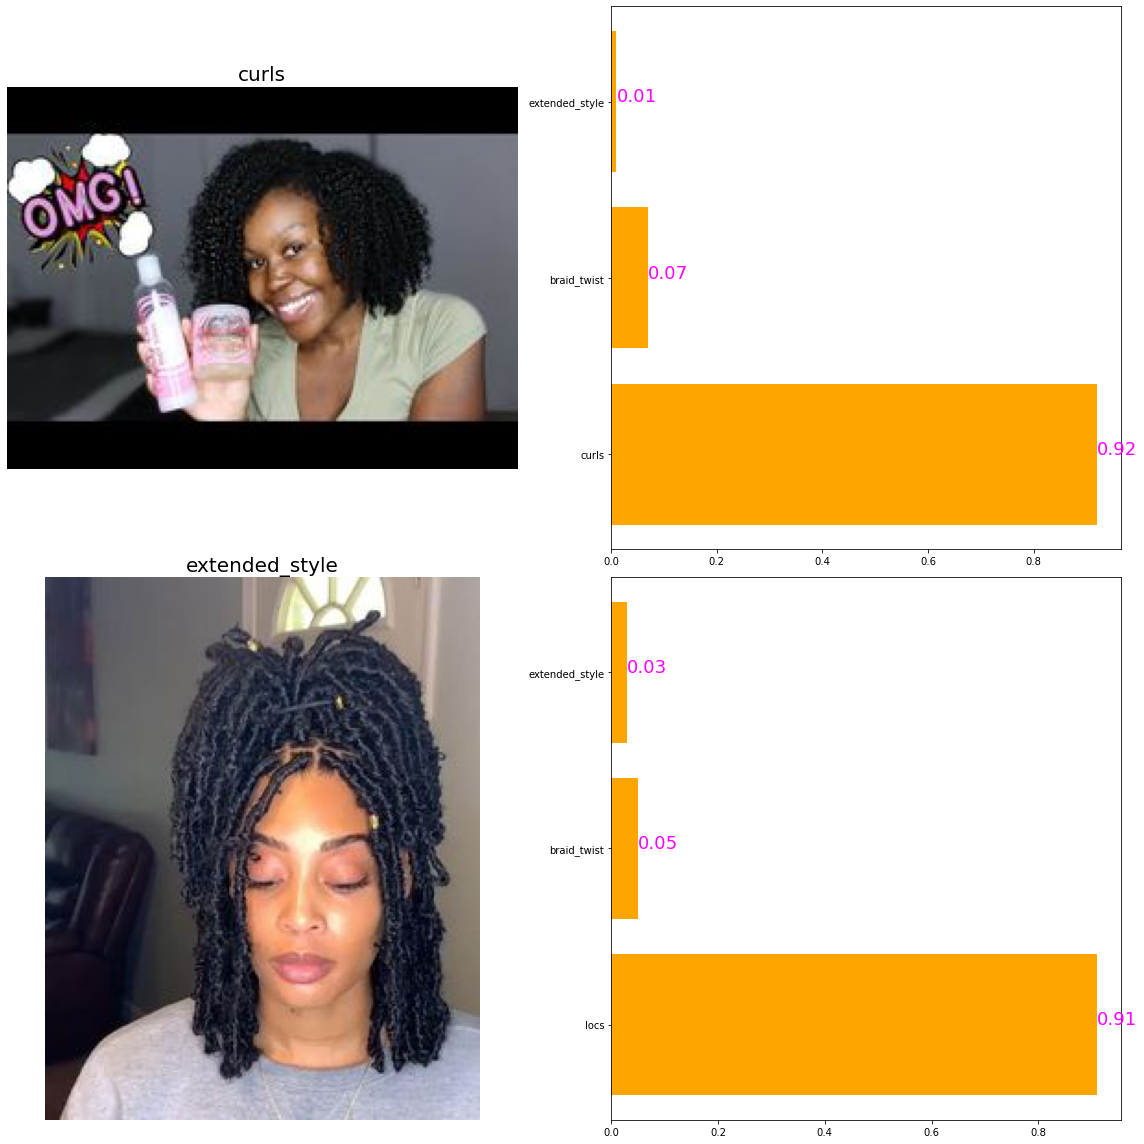

In [31]:
ShowPredictions(2,image_paths = test_image_paths,fig_name = 'predictions')

In [32]:
def GetMisClassifiedImagePaths(model,test_image_paths,top=2):
    misclass_image_paths = []
    topk_image_paths = []
    for i in range(len(test_image_paths)):
        top_probabilities, top_classes = GetClassProbs(model,test_image_paths[i],num_classes)
        label = test_image_paths[i].split('/')[-2]
        if label!=top_classes[0]:
            misclass_image_paths.append(test_image_paths[i])
            if label in top_classes[0:top]:
                topk_image_paths.append(test_image_paths[i])
    
    topk_accuracy = 1-(len(misclass_image_paths)-len(topk_image_paths))/len(test_image_paths)
    
    return misclass_image_paths,topk_image_paths,topk_accuracy

misclass_image_paths,topk_image_paths,topk_accuracy = GetMisClassifiedImagePaths(model,test_image_paths)
print(f'top2_accuracy: {topk_accuracy}')

top2_accuracy: 0.9471947194719472


- Now let's inspect some of the misclassified images. I am not sure if I could personally predict some of those images. Remember the model is as good as the data.

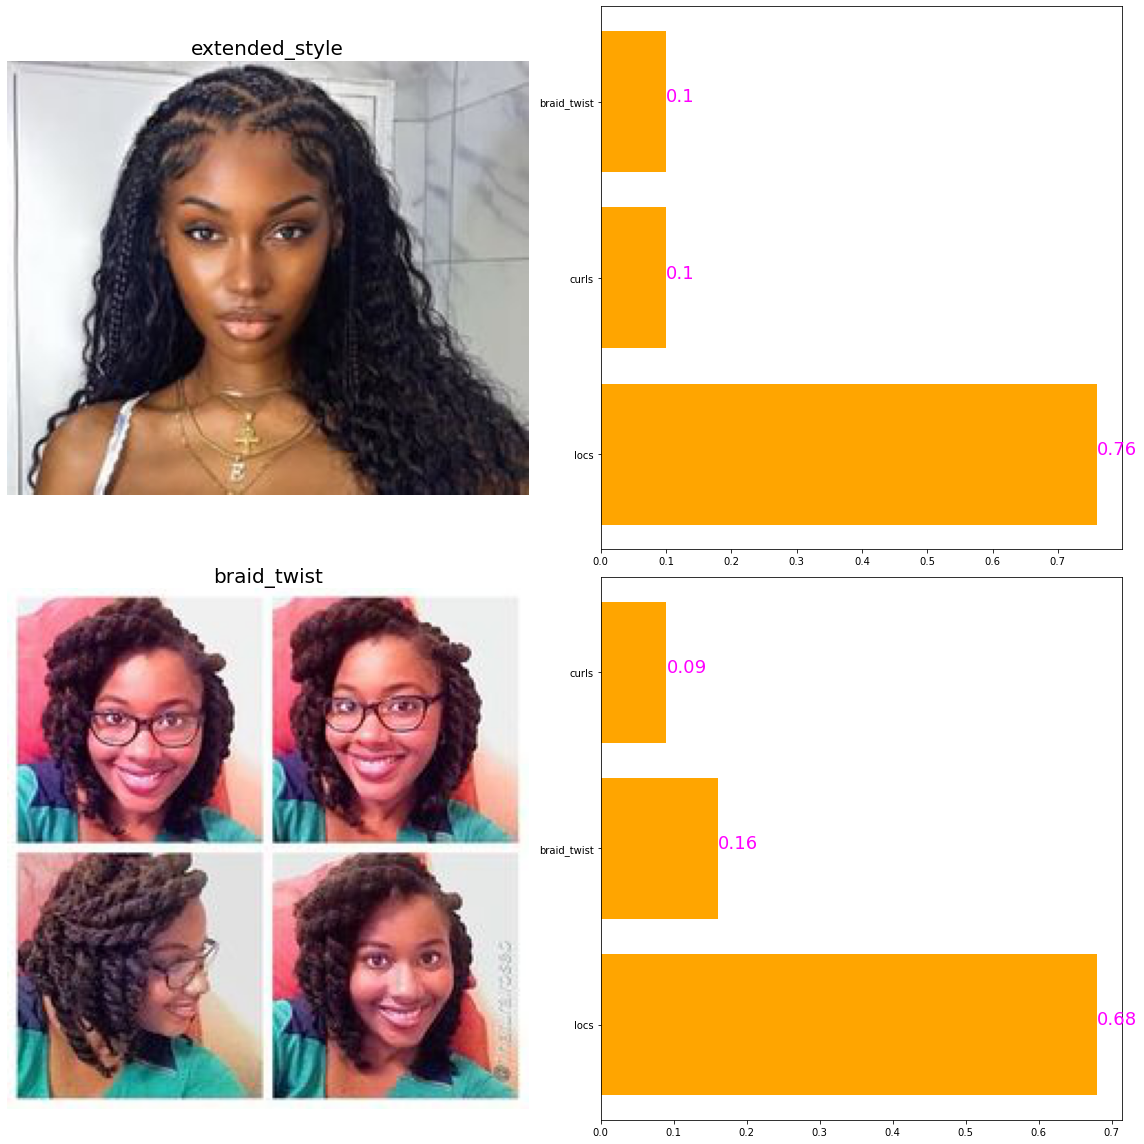

In [33]:
ShowPredictions(2,image_paths = misclass_image_paths,fig_name = 'misclassified')

### Evaluate the Performance Metrics

- For more details, consult to our lecture notes resources folder in this repo

#### Confusion Matrix

- The most important outcome of a classification problem is the confusion matrix. Each **row** of the matrix represents the instances **actual class** while each **column** represents the instances in a **predicted class**. 
-  Confusion matrix allows us to determine all the necessary metrics to evaluate the performance of an image classification model. First of all, let's see how we interpret confusion matrix for a simple scenario.
- Notice that comparing the previous model in Part-1, the metrics are way better.

In [34]:
def GetConfusionMatrix(model, test_loader):
    model.eval()
    model.to(device)
    with torch.no_grad():
        all_preds  = torch.FloatTensor([]).to(device)
        all_labels = torch.LongTensor([]).to(device)
        #compute all predictions
        for images, labels in iter(test_loader):
            images,labels = images.to(device),labels.to(device)
            preds = model(images)
            all_preds = torch.cat(
                (all_preds,preds),
                dim=0
            )
            all_labels = torch.cat((all_labels,labels),dim=0)
        
        #get the predicted labels
        preds = all_preds.argmax(dim=1)
        #create confusion matrix
        cm = confusion_matrix(all_labels.cpu().numpy(), preds.cpu().numpy())
        return cm
cm = GetConfusionMatrix(model,test_loader)

- Notice where most of the *confusion* occurs.  

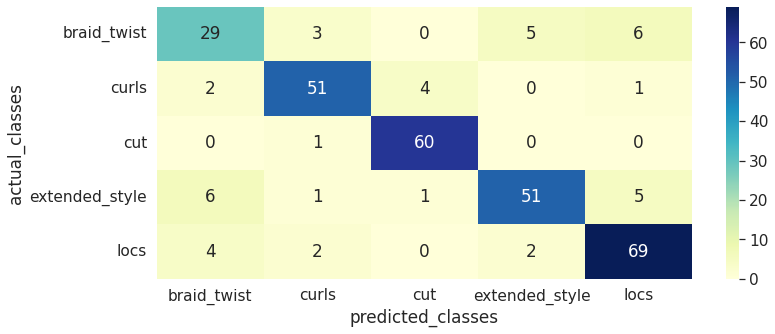

In [35]:
#display confusion matrix. truth:x_axis(rows), preds:y_axis(cols)
df_cm = pd.DataFrame(cm, index = [i for i in class_list], columns = [i for i in class_list])
plt.figure(figsize=(12,5))
sns.set(font_scale=1.4)
sns.heatmap(df_cm,annot=True,cmap="YlGnBu",fmt='g')
plt.xlabel('predicted_classes')
plt.ylabel('actual_classes')
plt.savefig(f'{ext_dir}/confusion_matrix.png')
plt.show()

In [36]:
#add text on top of barplot
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center',color='magenta')

def DisplayScores(class_list,scores,score_type = ''):
    fig, ax = plt.subplots(figsize=(9,4))
    ax.bar(class_list, scores,color='orange')
    ax.set_xticklabels(class_list, rotation=0)
    title = 'mean_' + score_type +':'+ str(np.round(scores.mean(),2))
    ax.set_title(title,color='magenta')
    addlabels(class_list,scores)
    plt.savefig(f'{ext_dir}/{score_type}.png')
    plt.show()

In [37]:
#returns major matrics
def GetScores(cm,score_type):
    accuracy = np.around(np.sum(np.diag(cm))/np.sum(cm),2)
    recalls = np.around(np.diag(cm)/np.sum(cm,axis = 1),2)
    precisions = np.around(np.diag(cm)/np.sum(cm,axis = 0),2)
    f1 = np.around( 2/(1/recalls + 1/precisions),2)
    if score_type=='accuracy':
        return accuracy
    if score_type=='recalls':
        return recalls
    if score_type=='precisions':
        return precisions
    if score_type=='F1':
        return f1
    else:
        print('Enter one of the score types \n accuracy,recalls,precisions or F1 ')

#### Overall Accuracy

In [38]:
# Be cautius, not always the best way
OveralAcc = GetScores(cm,score_type = 'accuracy')
print('OverallAccuracy', OveralAcc)

OverallAccuracy 0.86


#### Recall

- Recall tells us the ability of algoritm to classify a particular class. 

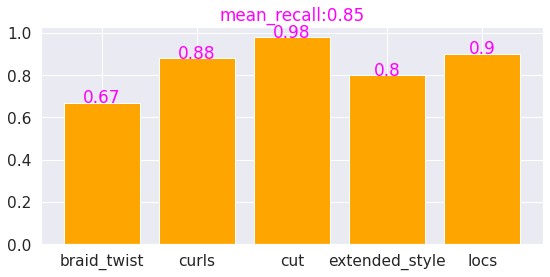

In [39]:
recalls = GetScores(cm,score_type = 'recalls')
DisplayScores(class_list,recalls,'recall')

#### Precision

- Precision for a class tells us the ability of an alg **not to label anything as that class**. 

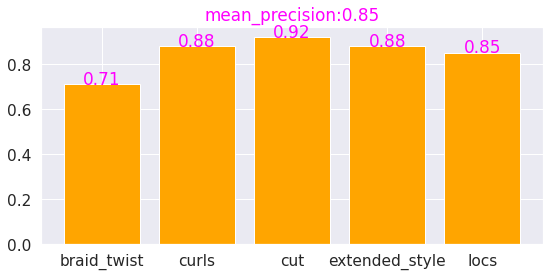

In [40]:
precisions = GetScores(cm,score_type = 'precisions')
DisplayScores(class_list,precisions,'precision')

#### F1-Score

This is the harmonic average of recall recall and precision. It is a reliable measure putting equal weights on precision and recall. It sits somewhere between precision and recall. 

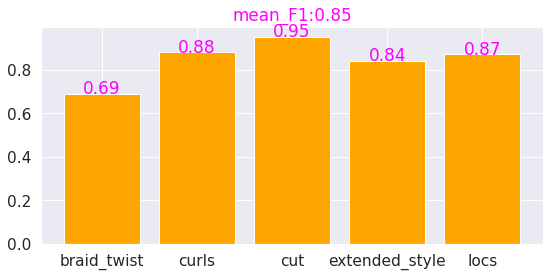

In [41]:
F1 = GetScores(cm,score_type='F1')
DisplayScores(class_list,F1,'F1')

## Model Interpretability

### Visualize Feature Maps

- The following function return all outputs of the convolutional layers in the model. We first register a hook to store convolutional feature maps in 'conv_outputs'. Them we define a subset of this dictionary 'vis_dict c' which includes only outputs whose image size (assuming square outputs) is greater than min_image_size. Recall that the ouput will look like (1,num_feature_maps,height, width) for a single image.

- Keys of vis_dict correspond the layer number of the corresponding convolutional layer. But it has nothing to do with the actual layer numbering of the model. It just tells how far is that layer in the model,i.e, smaller the key number, the earlier the layer. 

- We can then take these outputs and visualize them. Since some layers have tons of feature maps(i.e 144), we visualize only 64 at most. 

- Notice how each of the convolutional kernels reveal some patters. If the image is too dark(~ 0) or too white(~ 1), this points out to saturated filters.

In [42]:
#change this to look at the different images
sample_image_path = test_image_paths[25]
visualisation = {}
def hook_fn(m, i, o):
    visualisation[m] = o 

def GetAllConvolutionFeatureMaps1(model,image_path,min_image_size=14):
    
    layer_list = []
    selected_layers = []
    vis_dict = {}
    with torch.no_grad():
        model.to(device)
        model.eval()
        img = Image.open(image_path).convert("RGB")
        label = image_path.split('/')[-2]
        img = test_transforms(img)
        img = img.unsqueeze(0).to(device)
        for layer in model.modules():
            if isinstance(layer, torch.nn.modules.conv.Conv2d):
                layer.register_forward_hook(hook_fn)
                layer_list.append(layer)

        output = model(img)
    
    
    for i,j in enumerate(layer_list):
        layer_name = layer_list[i]
        out = visualisation[layer_name]
        if out.shape[3] >= min_image_size:
            selected_layers.append(layer_name)
            vis_dict[i] = out
    print(f'{len(vis_dict)}/{len(layer_list)} convolutional layers is selected')
    return vis_dict,selected_layers


vis_dict,selected_layers = GetAllConvolutionFeatureMaps1(model,sample_image_path,min_image_size=14)

34/81 convolutional layers is selected


In [43]:
# print(selected_layers[0])
#these are ranking of the layers in the vis_dict
print(vis_dict.keys())

dict_keys([0, 1, 4, 5, 6, 9, 10, 11, 14, 15, 16, 19, 20, 21, 24, 25, 26, 29, 30, 31, 34, 35, 36, 39, 40, 41, 44, 45, 46, 49, 50, 51, 54, 55])


feature map size: 112x112


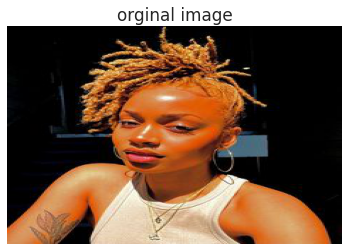

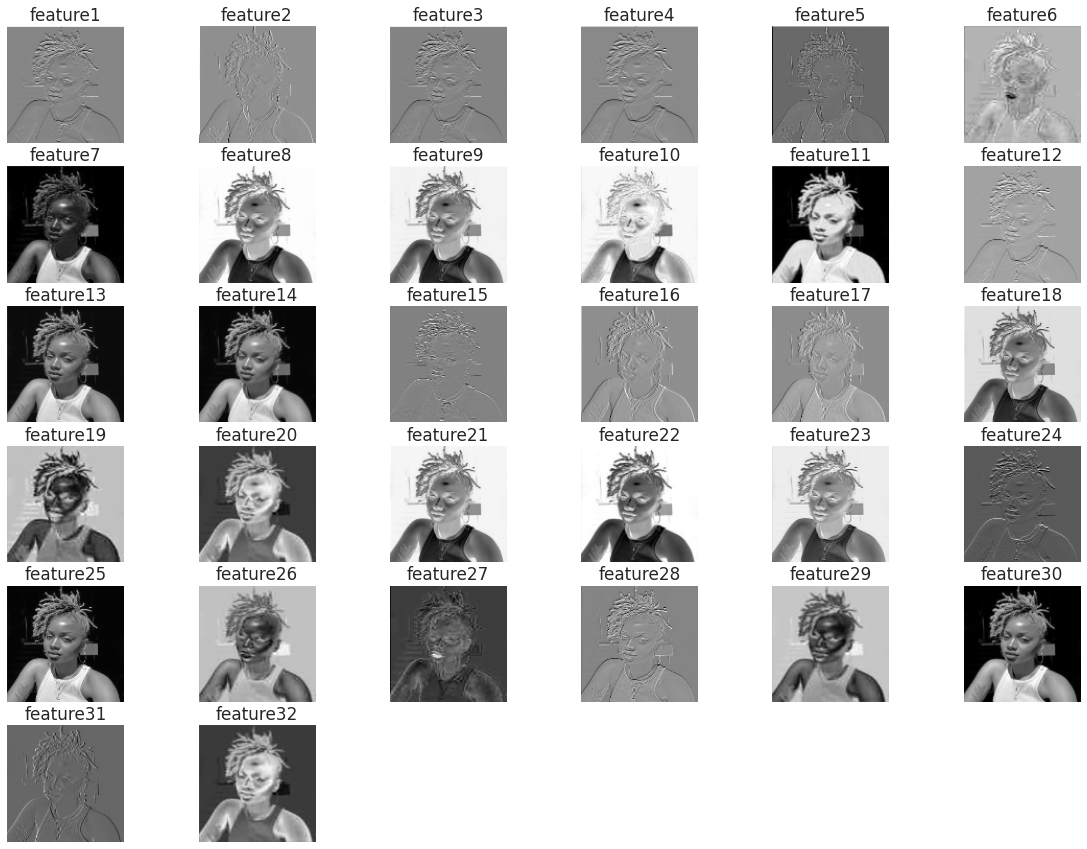

In [44]:
def VisualizeFeatureMaps(vis_dict,image_path,layer_num=0):
    img = Image.open(image_path).convert('RGB')
    plt.imshow(img,aspect='auto')
    plt.axis('off')
    plt.title('orginal image')
    plt.savefig(f'{ext_dir}/original_image.png')
    output = vis_dict[layer_num]
    print(f'feature map size: {output.shape[2]}x{output.shape[2]}')
    num_feature_maps = output[0].shape[0]
    if num_feature_maps<=64:
        s = int(np.ceil(np.sqrt(num_feature_maps)))
    else:
        print(f'I will display 64/{num_feature_maps} feature maps!')
        s = 8
    plt.figure(figsize=(20, 15))
    for i, image in enumerate(output[0]):
        if i==64:
            break
        #image = image - image.min()
        #image = image / image.max()
        image = image.squeeze(0)
        plt.subplot(s,s,i+1)
        plt.imshow(image.cpu().numpy(),cmap='gray')
        plt.title(f'feature{i+1}')
        plt.axis('off')
        plt.savefig(f'{ext_dir}/feature_maps_layer{layer_num}.png')

VisualizeFeatureMaps(vis_dict,sample_image_path,layer_num=0)       

### Model Interpretability with Captum

- This section is just a demonstration. As we discussed before, we mostly lose the interpretability from linear regression to neural networks. However, we can gain some insight to some extent making some experiments.
- Basic idea is to check how model features(neurons, layers etc) effect the outcome, prediction. This is an active research area. Just grab an image and give the following function. 
- Focus on the dark-yellow ish fields...

In [45]:
# def InspectCaptum(model,image_path):

#     imgPIL = Image.open(image_path).convert("RGB")
#     img = test_transforms(imgPIL)
#     img = img.unsqueeze(0).to(device)
#     label = image_path.split('/')[-2]
#     occlusion = Occlusion(model)
#     strides = (1, 5, 5)               # smaller = more fine-grained attribution but slower
#     target = class_to_idx[label],     # index of the image
#     sliding_window_shapes=(1,10, 10)  # choose size enough to change object appearance
#     baselines = 0                     # values to occlude the image with. 0 corresponds to gray

#     attribution = occlusion.attribute(img,
#                                        strides = strides,
#                                        target=target,
#                                        sliding_window_shapes=sliding_window_shapes,
#                                        baselines=baselines,
#                                        show_progress=True)

#     attribution_np = np.transpose(attribution.squeeze().cpu().data.numpy(), (1,2,0))
#     image_np = np.array(imgPIL)


#     vis_types = ["blended_heat_map", "original_image"]
#     vis_signs = ["all", "positive"] # "positive", "negative", or "all" to show both
#     # positive attribution indicates that the presence of the area increases the prediction score
#     # negative attribution indicates distractor areas whose absence increases the score

#     _ = viz.visualize_image_attr_multiple(attribution_np,
#                                           image_np,
#                                           vis_types,
#                                           vis_signs,
#                                           ["Occlusion", f"{label}"],
#                                           cmap = "plasma",
#                                           fig_size=(8, 8),
#                                           alpha_overlay=0.7
#                                          )



In [46]:
# InspectCaptum(model,test_image_paths[20])

In [47]:
if colab:
    !zip -r '/content/results.zip' '/content/results'
    files.download("/content/results.zip")